# 라이브러리

In [1]:
!pip install imblearn

In [2]:
#lib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image 
import cv2
import sys
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import layers as tfl, optimizers

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from imblearn.over_sampling import SMOTE

# 데이터 불러오기

In [3]:
## 코랩에서 돌아가던 파일이 현재 작동되지않아 로컬에서 진행
## 구글코랩과 캐글 연동 과정은 생략
## https://www.kaggle.com/datasets/divyansh22/dummy-astronomy-data
# # 캐글연동
# !pip install kaggle
# from google.colab import files
# files.upload()

In [4]:
# ls -1ha kaggle.json

In [5]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning이 발생하지 않도록 해줍니다.
# !chmod 600 ~/.kaggle/kaggle.json

In [6]:
# !kaggle datasets download -d divyansh22/dummy-astronomy-data

In [7]:
# !unzip dummy-astronomy-data.zip

In [8]:
#데이터 불러오기 & 라벨링
data = []
labels =[]
import glob
galaxy_path = glob.glob('./Cutout Files/galaxy/*')
star_path = glob.glob('./Cutout Files/star/*')
for x in galaxy_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(0)
for x in star_path:
    image = cv2.imread(x,1)
    image= np.array(image)
    data.append(image)
    labels.append(1)   

In [9]:
data, labels= np.array(data), np.array(labels)

In [10]:
dataset= pd.DataFrame(list(zip(data, labels)), columns=['images','labels'])

In [11]:
dataset.head(5)

,images,labels
0,"[[[45, 45, 45], [99, 99, 99], [38, 38, 38], [1...",0
1,"[[[103, 103, 103], [89, 89, 89], [46, 46, 46],...",0
2,"[[[149, 149, 149], [178, 178, 178], [200, 200,...",0
3,"[[[93, 93, 93], [98, 98, 98], [121, 121, 121],...",0
4,"[[[101, 101, 101], [80, 80, 80], [100, 100, 10...",0


# 데이터 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42, shuffle=True,stratify=dataset['labels'].values)

x_train, x_valid, y_train, y_valid= train_test_split(x_train, y_train, test_size=0.2,
                                                random_state=42, shuffle=True)

# 데이터 오버샘플링

In [13]:
x_train.shape,y_train.shape

((2550, 64, 64, 3), (2550,))

In [14]:
# 타겟값의 비율이 약 1:3으로 불균형하다고 판단되어 오버샘플링 진행 SMOTE
np.unique(y_train,return_counts = True)

(array([0, 1]), array([ 605, 1945]))

In [15]:
sm = SMOTE(random_state=42)

# SMOTE 모듈을 사용하기위해 x_train을 4차원에서 2차원으로 변형시켰고, 추후에 복원

train_rows=len(x_train)
x_train=x_train.reshape(train_rows,-1)

In [16]:
x_train.shape

(2550, 12288)

In [17]:
x_train,y_train=sm.fit_resample(x_train,y_train)

In [18]:
x_train=x_train.reshape(-1,64,64,3)

In [19]:
# 최종적으로 훈련데이터의 수는 2550->3890으로 오버샘플링됨
x_train.shape

(3890, 64, 64, 3)

In [20]:
# 오버샘플링을 통해 5:5로 훈련데이터의 타겟값을 만들었다
np.unique(y_train,return_counts = True)

(array([0, 1]), array([1945, 1945]))

In [21]:
y_train, y_valid= to_categorical(y_train),  to_categorical(y_valid)

In [22]:
x_train.shape,y_train.shape

((3890, 64, 64, 3), (3890, 2))

In [23]:
x_valid.shape,y_valid.shape

((638, 64, 64, 3), (638, 2))

In [24]:
x_test.shape,y_test.shape

((798, 64, 64, 3), (798,))

# 데이터 확인

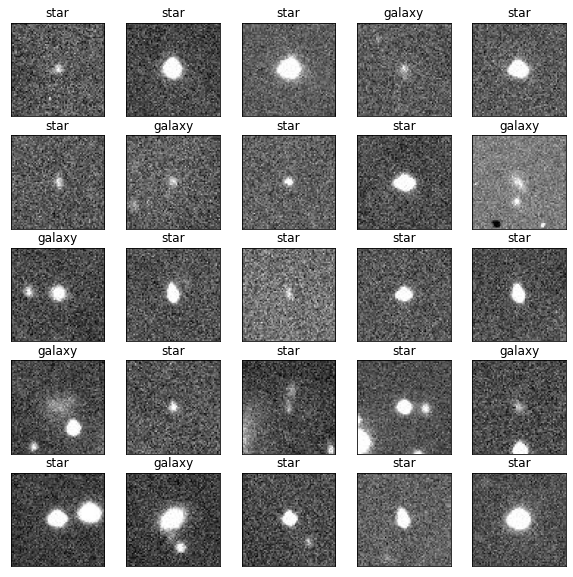

In [25]:
class_names=['star','galaxy']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    if y_test[i]==0:
    #if y_test[i][0]==0:
        plt.title('galaxy')
    else:
        plt.title('star')
    #plt.xlabel(class_names[y_train[i][0]])
plt.show()

# 모델링

## resnet50

In [26]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape = (64,64,3),classes=2)

for layer in resnet.layers:
    layer.trainable = False

2022-08-18 18:33:26.229868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-18 18:33:26.230090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [27]:
from keras.layers import BatchNormalization,Dropout

x = resnet.output
x = Rescaling(scale=1./255)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x =  Dense(512, activation='relu', input_dim=(64,64,3))(x)
x = BatchNormalization()(x)
x =  Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=x)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [29]:
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]

In [30]:
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy', 
    metrics=METRICS
)

In [31]:
import os
paths = {'model_path' : os.path.join('models'), 
         'weights_path' : os.path.join('models','weights'),
         'saved_model_path' : os.path.join('models', 'saved_model'),
         'checkpoint_path' : os.path.join('models','checkpoints')
        }

## callback

In [32]:
# call back

# checkpoint - best model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
model_ckpt= ModelCheckpoint(
                        paths['checkpoint_path'], monitor='val_auc', verbose=1, save_best_only=True,
                         mode='max', save_freq='epoch')

# learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.2,
                              patience=4, min_lr=0.001)

# es = EarlyStopping(monitor='val_auc', mode='auto', verbose=1,
#                   restore_best_weights=True,patience=10)

In [33]:
# x_train= tfl.Rescaling(scale=1./255)(x_train)
# x_valid=tfl.Rescaling(scale=1./255)(x_valid)

## fitting

In [34]:
epochs = 128
history = model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    verbose=1,
                    batch_size=32,
                    callbacks=[model_ckpt,reduce_lr]
                    #callbacks=[es]
                    )

Epoch 1/128


2022-08-18 18:33:28.543680: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-18 18:33:30.409232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


122/122 [==============================] - ETA: 0s - loss: 0.4038 - tp: 3163.0000 - fp: 727.0000 - tn: 3163.0000 - fn: 727.0000 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.9026 - prc: 0.8980

2022-08-18 18:33:39.564279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_auc improved from -inf to 0.87942, saving model to models/checkpoints


2022-08-18 18:33:44.617974: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/checkpoints/assets
122/122 [==============================] - 26s 190ms/step - loss: 0.4038 - tp: 3163.0000 - fp: 727.0000 - tn: 3163.0000 - fn: 727.0000 - accuracy: 0.8131 - precision: 0.8131 - recall: 0.8131 - auc: 0.9026 - prc: 0.8980 - val_loss: 0.5015 - val_tp: 497.0000 - val_fp: 141.0000 - val_tn: 497.0000 - val_fn: 141.0000 - val_accuracy: 0.7790 - val_precision: 0.7790 - val_recall: 0.7790 - val_auc: 0.8794 - val_prc: 0.8855 - lr: 0.0100
Epoch 2/128
122/122 [==============================] - ETA: 0s - loss: 0.3313 - tp: 3283.0000 - fp: 607.0000 - tn: 3283.0000 - fn: 607.0000 - accuracy: 0.8440 - precision: 0.8440 - recall: 0.8440 - auc: 0.9300 - prc: 0.9267
Epoch 2: val_auc improved from 0.87942 to 0.90582, saving model to models/checkpoints
INFO:tensorflow:Assets written to: models/checkpoints/assets
122/122 [==============================] - 22s 181ms/step - loss: 0.3313 - tp: 3283.0000 - fp: 607.0000 - tn: 3283.0000 - fn: 607.0000 - 

In [35]:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(paths['checkpoint_path'])
# loaded_model.summary()

# 시각화

## 훈련 과정 시각화

In [36]:
training_score= history.history

Text(0.5, 1.0, 'Loss Function')

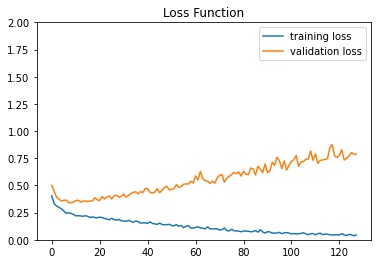

In [37]:
plt.plot(training_score['loss'], label='training loss')
plt.plot(training_score['val_loss'], label='validation loss')
plt.ylim(0,2)
plt.legend()
plt.title('Loss Function')

Text(0.5, 1.0, 'AUC Function')

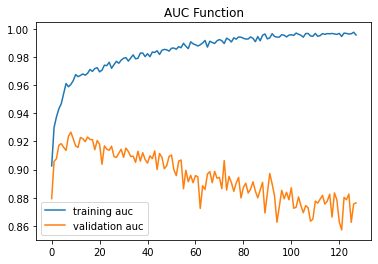

In [38]:
plt.plot(training_score['auc'], label='training auc')
plt.plot(training_score['val_auc'], label='validation auc')
plt.legend()
plt.title('AUC Function')

Text(0.5, 1.0, 'Precision Function')

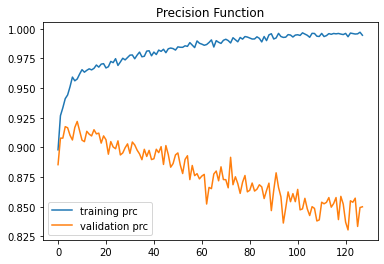

In [39]:
plt.plot(training_score['prc'], label='training prc')
plt.plot(training_score['val_prc'], label='validation prc')
plt.legend()
plt.title('Precision Function')

## 베스트 모델로 test 데이터의 ROC Curve 확인

In [40]:
model_name= 'resent_star_galaxy.h5'
model.save(paths['saved_model_path'] + model_name)

In [41]:
from sklearn.metrics import roc_curve, auc

In [42]:
loaded_saved_model= keras.models.load_model(paths['saved_model_path']+model_name)
loaded_saved_ckpt= keras.models.load_model(paths['checkpoint_path'])

In [43]:
def evaluate_results(x,y, classes):
    predicted_prob = loaded_saved_ckpt.predict(x)
    fpr= {}
    tpr ={}
    threshold_ ={}
    auc_ ={}
    for i in range(classes):
        fpr[i], tpr[i], threshold_[i]= roc_curve(y, predicted_prob[:,i], pos_label=i)
        auc_[i] = auc(fpr[i], tpr[i])      
    
    return fpr, tpr, threshold_, auc_    

In [44]:
num_classes= 2
fpr, tpr, threshold_, auc_score= evaluate_results(x_test,y_test, num_classes)

2022-08-18 18:53:38.798325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


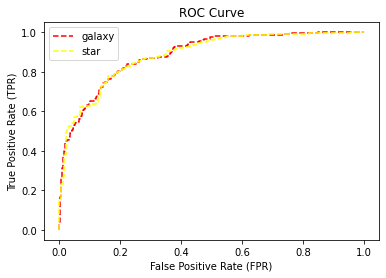

********** 
 AUC score for class GALAXY:  0.8861000338832852 
 ********** 
 AUC score for class STAR:  0.8861000338832852 
 **********


In [45]:
plt.plot(fpr[0],tpr[0], linestyle='--',color='red', label='galaxy')
plt.plot(fpr[1],tpr[1], linestyle='--',color='yellow', label='star')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()
print('*'*10,'\n','AUC score for class GALAXY: ', auc_score[0], '\n', '*'*10,'\n', 'AUC score for class STAR: ', auc_score[1], '\n', '*'*10)